In [1]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, text

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem
from nacsos_data.db.schemas import AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None
db_engine = get_engine(conf_file='../.config/remote.env')

PROJECT_ID = '3d761435-fe4f-4829-a33e-26fc52a46613'
SCHEME_ID = '4658a522-0626-4074-b207-ed46ea13d2a1'

JOSEFINE = '45c63ef0-2af7-4652-b096-cff368497fea'
FELIX = '6f57074c-b145-4826-a20c-2aba8939758f'
LYNN = '8049cefa-6f2a-4fed-8b71-ca9424dd99c6'
NIKOLA = '3cd7dc2a-f920-4699-898e-7760ef7fb063'

In [2]:
with db_engine.session() as session:
    rslt = session.execute(select(Import).where(Import.project_id == PROJECT_ID)).scalars().all()
    for r in rslt:
        print(f"('{r.import_id}', '{r.name}'),")

('419bd950-7847-4df3-959f-8c98e6bfb863', 'Updated WoS (01.07.2024) | Waste'),
('3b36cac1-89f5-45da-bb63-63d575cc7ac5', 'Updated WoS (01.07.2024) | Buildings'),
('8ea4d66e-3918-48f4-9bc6-574feb885dcd', 'Updated WoS (01.07.2024) | Bikes'),
('beb43723-d07a-4224-999e-d4e50f5b0744', 'Original data (urban form)'),
('b5ea5cff-7856-433f-a6ec-2c5510a23293', 'Original data (buildings)'),
('18a17c5f-c96d-4fa4-b0a1-a639193ea1f7', 'Original data (transport)'),
('a8de6a28-1e92-4468-8fa9-30dd9fa4df83', 'Updated WoS (01.07.2024) | Transport'),
('dce23cb8-901a-42ef-995d-e2b2dc7ddce3', 'Original data (bikes and scooters)'),
('13ef9fb4-8d10-4a1e-b35d-3c8b7d6f4ad3', 'Original data (waste)'),
('1e799d77-c6f1-4f25-916f-07f6a1189351', 'Updated WoS (01.07.2024) | Urban form'),


In [3]:
with db_engine.session() as session:
    rslt = session.execute(
        select(AssignmentScope).where(AssignmentScope.annotation_scheme_id == SCHEME_ID)).scalars().all()
    for r in rslt:
        print(f"('{r.assignment_scope_id}', '{r.name}'),")
    print('----')
    rslt = session.execute(select(BotAnnotationMetaData).where(BotAnnotationMetaData.annotation_scheme_id == SCHEME_ID,
                                                               BotAnnotationMetaData.kind == 'RESOLVE')).scalars().all()
    for r in rslt:
        print(f"('{r.bot_annotation_metadata_id}', '{r.name}'),")

('599a1074-cb9f-4ed0-976d-8139633c6e88', 'Imported from sheet "waste" in "AllRecords.xlsx"'),
('d4e5c1b0-d2c5-4a77-877b-5226ead1f8bf', 'Imported from sheet "urban form" in "AllRecords.xlsx"'),
('dbe0545e-68a6-43e5-b08c-8639281b24bb', 'Imported from sheet "buildings" in "AllRecords.xlsx"'),
('67ec81fe-ebce-438c-8f6e-519b2f4b50ff', 'Imported from sheet "transport" in "AllRecords.xlsx"'),
('ec384280-a445-43de-b467-2cce7a048391', 'Imported from sheet "bikes and scooters" in "AllRecords.xlsx"'),
('d3a90301-3a63-431c-9510-f99c33fab7ab', 'Imported from "SI_3_relevant.xlsx"'),
('dae6166c-5ba1-4a94-8662-6da1f9706b7d', '20240702_all_waste_JH_NM'),
('fe13ee6b-39dc-4235-a894-14b9a157941f', 'Tim'),
----
('b386ae78-ae35-428a-be34-abceab9dba3f', 'Resolution for "Waste"'),
('0057dc42-5821-445b-b3d5-834d0958d110', 'Resolution for "urban form"'),
('c42b71c7-f1dc-46b2-b187-72fa78f8a397', 'Resolution for "buildings"'),
('c77b8462-7ab5-4bac-b686-6008c8fbe727', 'Resolution for "transport"'),
('23e57f61-8279

In [4]:
sources = [i for i, _ in [('b386ae78-ae35-428a-be34-abceab9dba3f', 'Resolution for "Waste"'),
                          ('0057dc42-5821-445b-b3d5-834d0958d110', 'Resolution for "urban form"'),
                          ('c42b71c7-f1dc-46b2-b187-72fa78f8a397', 'Resolution for "buildings"'),
                          ('c77b8462-7ab5-4bac-b686-6008c8fbe727', 'Resolution for "transport"'),
                          ('be1361b6-35ed-4509-bc2a-da10c9d83e91', 'Resolution for "bikes and scooters"')]]

with db_engine.session() as session:
    stmt = (select(AcademicItem, BotAnnotation.value_int.label('incl'))
            .join(BotAnnotation, BotAnnotation.item_id == AcademicItem.item_id)
            .where(BotAnnotation.bot_annotation_metadata_id.in_(sources),
                   BotAnnotation.key == 'incl'))
    rslt = session.execute(stmt).mappings().all()
    labels = [{
        'item_id': str(r['AcademicItem'].item_id),
        'title': r['AcademicItem'].title,
        'abstract': r['AcademicItem'].text,
        'text': f"{r['AcademicItem'].title} {r['AcademicItem'].text}",
        'py': r['AcademicItem'].publication_year,
        'incl': r['incl']
    } for r in rslt]

df = pd.DataFrame(labels).replace({np.nan: None})
df['label'] = df['incl']
df

item_id  \
0     00ba8533-fcb4-45a6-9d0b-0857d69cfee6   
1     01ab7d0d-7c81-4810-8cb2-f879a4ed7e14   
2     0326c8b7-9545-46b8-9df8-e21402643fab   
3     03335a32-841e-4b6e-9d06-5bdce6d091fa   
4     03f3f1ea-7880-4261-a4a0-9779153fc21c   
...                                    ...   
2853  fc0742fd-7f08-48d5-b1bf-56e1031ab033   
2854  fc53e24e-9ce8-4bbf-a28b-85975485a97a   
2855  fdb52935-8c80-4ef4-b238-f87cc7489b01   
2856  fe4e962f-7e62-44b3-be4b-b35ceefbd218   
2857  ff64b3fa-a068-4ca5-b694-a0411d2e6d40   

                                                  title  \
0     Artificial NEURAL NETWORK based Smart and ENER...   
1     Triangular NEIGHBORHOOD Function for Self-Orga...   
2     A Vision-Based Precipitation Sensor for Detect...   
3     Offshore wind farms in Southern Europe - Deter...   
4     User-Aware and Flexible Proactive Caching Usin...   
...                                                 ...   
2853  Time dimension analysis: Comparison of Nanjing...   
2854  A hybrid ridesharing algorithm based on GIS an...   
2855  Short-term forecasting of the Abu Dhabi elecTR...   
2856  DisTRIBUTION Network Model Platform: A First C...   
2857  Using a Self-Organizing Map to Explore Local W...   

                                               abstract  \
0     Smart CITY is the term described to integrate ...   
1     The paper presents a novel transistor level im...   
2     Measuring precipitation is an important part o...   
3     There is increasing consensus that resistance ...   
4     To meet the stringent demands of emerging Inte...   
...                                                 ...   
2853  Driving cycles are widely USED as standard mea...   
2854  The increasing use of private cars in large ci...   
2855  Short term load forecasting, ranging from a fe...   
2856  DECARBONISATION POLICIES have recently seen an...   
2857  Weather plays a critical role in outdoor agric...   

                                                   text      py  incl  label  
0     Artificial NEURAL NETWORK based Smart and ENER...  2019.0     1      1  
1     Triangular NEIGHBORHOOD Function for Self-Orga...  2016.0     0      0  
2     A Vision-Based Precipitation Sensor for Detect...  2016.0     0      0  
3     Offshore wind farms in Southern Europe - Deter...  2015.0     0      0  
4     User-Aware and Flexible Proactive Caching Usin...  2022.0     0      0  
...                                                 ...     ...   ...    ...  
2853  Time dimension analysis: Comparison of Nanjing...  2020.0     1      1  
2854  A hybrid ridesharing algorithm based on GIS an...  2021.0     1      1  
2855  Short-term forecasting of the Abu Dhabi elecTR...  2015.0     1      1  
2856  DisTRIBUTION Network Model Platform: A First C...  2019.0     0      0  
2857  Using a Self-Organizing Map to Explore Local W...  2021.0     0      0  

[2858 rows x 7 columns]

In [5]:
df['incl'].value_counts()

incl
0    1659
1    1199
Name: count, dtype: int64

In [6]:
import numpy as np

import torch
import evaluate
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForMaskedLM

model_name = 'climatebert/distilroberta-base-climate-f'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
#model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

dataset = Dataset.from_pandas(df)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
encoded_dataset = dataset.map(lambda rows: tokenizer([f'{t} {a}' for t,a in zip(rows['title'], rows['abstract'])], padding='max_length', truncation=True), batched=True)

n_total = len(dataset)
n_eval = int(0.2 * n_total)
n_train = n_total - n_eval

shuffeled_dataset = encoded_dataset.shuffle()

# Split the dataset into train and test
train_dataset = shuffeled_dataset.select(range(n_train))
eval_dataset = shuffeled_dataset.select(range(n_train, n_total))

print('train', n_train)
print('eval', n_eval)

2024-07-03 14:54:24,883 [INFO] datasets: PyTorch version 2.3.1 available.
2024-07-03 14:54:24,884 [INFO] datasets: TensorFlow version 2.16.1 available.
2024-07-03 14:54:25.189750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 14:54:25.727511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Map:   0%|          | 0/2858 [00:00<?, ? examples/s]

train 2287
eval 571


In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='data/results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='data/logs',
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=100,
)

metrics1 = evaluate.combine(["recall", "precision"])
metrics2 = evaluate.combine(["accuracy", "f1"])

a=None
def compute_metrics(p):
    a=p
    logits, labels = p
    print(p)
    predictions = np.argmax(logits, axis=-1)
    m1 = metrics1.compute(predictions=predictions, references=labels, zero_division=0, average="binary")
    m2 = metrics2.compute(predictions=predictions, references=labels)
    return {**m1, **m2}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

metrics = evaluate.combine(["recall", "precision", "accuracy", "f1"])

task_evaluator = evaluate.evaluator("text-classification")
eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    data=train_dataset,
    metric=metrics,
)
print(eval_results)
eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    data=eval_dataset,
    metric=metrics,
)
print(eval_results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon INFO @ 14:54:40] [setup] RAM Tracking...
[codecarbon INFO @ 14:54:40] [setup] GPU Tracking...
[codecarbon INFO @ 14:54:40] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:54:40] [setup] CPU Tracking...
[codecarbon WARNING @ 14:54:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 14:54:41] We saw that you have a AMD Ryzen 7 5700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 14:54:41] CPU Model on constant consumption mode: AMD Ryzen 7 5700X 8-Core Processor
[codecarbon INFO @ 14:54:41] >>> Tracker's metadata:
[codecarb

[codecarbon INFO @ 14:55:00] Energy consumed for RAM : 0.000098 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:55:00] Energy consumed for all GPUs : 0.000578 kWh. Total GPU Power : 138.67232886644592 W
[codecarbon INFO @ 14:55:00] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:00] 0.000853 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:15] Energy consumed for RAM : 0.000196 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:55:15] Energy consumed for all GPUs : 0.001198 kWh. Total GPU Power : 148.80440255455147 W
[codecarbon INFO @ 14:55:15] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:15] 0.001748 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:55:30] Energy consumed for RAM : 0.000294 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:55:30] Energy consumed for all GPUs : 0.001813 kWh. Total GPU Power : 147.70498508933284 W
[codecarbon INFO @ 14:55:30] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:30] 0.002638 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:55:45] Energy consumed for RAM : 0.000392 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:55:45] Energy consumed for all GPUs : 0.002426 kWh. Total GPU Power : 147.07485320346632 W
[codecarbon INFO @ 14:55:45] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:55:45] 0.003526 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:56:00] Energy consumed for RAM : 0.000490 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:56:00] Energy consumed for all GPUs : 0.003049 kWh. Total GPU Power : 149.52033182476666 W
[codecarbon INFO @ 14:56:00] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:00] 0.004424 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:15] Energy consumed for RAM : 0.000588 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:56:15] Energy consumed for all GPUs : 0.003668 kWh. Total GPU Power : 148.61538588795557 W
[codecarbon INFO @ 14:56:15] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:15] 0.005318 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:56:30] Energy consumed for RAM : 0.000686 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:56:30] Energy consumed for all GPUs : 0.004288 kWh. Total GPU Power : 148.79753820802708 W
[codecarbon INFO @ 14:56:30] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:30] 0.006213 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:56:45] Energy consumed for RAM : 0.000784 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:56:45] Energy consumed for all GPUs : 0.004905 kWh. Total GPU Power : 148.1656694290843 W
[codecarbon INFO @ 14:56:45] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:56:45] 0.007106 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:57:00] Energy consumed for RAM : 0.000882 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:57:00] Energy consumed for all GPUs : 0.005517 kWh. Total GPU Power : 146.8135710495657 W
[codecarbon INFO @ 14:57:00] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:00] 0.007992 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:15] Energy consumed for RAM : 0.000980 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:57:15] Energy consumed for all GPUs : 0.006140 kWh. Total GPU Power : 149.537235238728 W
[codecarbon INFO @ 14:57:15] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:15] 0.008890 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:57:30] Energy consumed for RAM : 0.001078 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:57:30] Energy consumed for all GPUs : 0.006712 kWh. Total GPU Power : 137.0212348962956 W
[codecarbon INFO @ 14:57:30] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:30] 0.009737 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:57:45] Energy consumed for RAM : 0.001176 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:57:45] Energy consumed for all GPUs : 0.007335 kWh. Total GPU Power : 149.6160578216036 W
[codecarbon INFO @ 14:57:45] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:57:45] 0.010636 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:58:00] Energy consumed for RAM : 0.001274 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:58:00] Energy consumed for all GPUs : 0.007948 kWh. Total GPU Power : 147.09570531927562 W
[codecarbon INFO @ 14:58:00] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:00] 0.011524 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:15] Energy consumed for RAM : 0.001372 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:58:15] Energy consumed for all GPUs : 0.008561 kWh. Total GPU Power : 147.15251300518418 W
[codecarbon INFO @ 14:58:15] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:15] 0.012412 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:58:30] Energy consumed for RAM : 0.001469 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:58:30] Energy consumed for all GPUs : 0.009187 kWh. Total GPU Power : 150.18902063939655 W
[codecarbon INFO @ 14:58:30] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:30] 0.013313 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:58:45] Energy consumed for RAM : 0.001567 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:58:45] Energy consumed for all GPUs : 0.009804 kWh. Total GPU Power : 148.0913268177714 W
[codecarbon INFO @ 14:58:45] Energy consumed for all CPUs : 0.002834 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:45] 0.014205 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:59:00] Energy consumed for RAM : 0.001665 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:59:00] Energy consumed for all GPUs : 0.010411 kWh. Total GPU Power : 145.77828565468542 W
[codecarbon INFO @ 14:59:00] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:00] 0.015087 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:15] Energy consumed for RAM : 0.001763 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:59:15] Energy consumed for all GPUs : 0.011046 kWh. Total GPU Power : 152.35338487236478 W
[codecarbon INFO @ 14:59:15] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:15] 0.015997 kWh of electricity used since the beginning.


[codecarbon INFO @ 14:59:30] Energy consumed for RAM : 0.001861 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:59:30] Energy consumed for all GPUs : 0.011662 kWh. Total GPU Power : 147.8171652566033 W
[codecarbon INFO @ 14:59:30] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:30] 0.016888 kWh of electricity used since the beginning.
[codecarbon INFO @ 14:59:45] Energy consumed for RAM : 0.001959 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 14:59:45] Energy consumed for all GPUs : 0.012272 kWh. Total GPU Power : 146.44575325178695 W
[codecarbon INFO @ 14:59:45] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:45] 0.017773 kWh of electricity used since the beginning.


[codecarbon INFO @ 15:00:00] Energy consumed for RAM : 0.002058 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 15:00:00] Energy consumed for all GPUs : 0.012862 kWh. Total GPU Power : 141.05139937168636 W
[codecarbon INFO @ 15:00:00] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:00] 0.018640 kWh of electricity used since the beginning.
[codecarbon INFO @ 15:00:15] Energy consumed for RAM : 0.002156 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 15:00:15] Energy consumed for all GPUs : 0.013486 kWh. Total GPU Power : 149.79945821684396 W
[codecarbon INFO @ 15:00:15] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:15] 0.019539 kWh of electricity used since the beginning.


[codecarbon INFO @ 15:00:29] Energy consumed for RAM : 0.002251 kWh. RAM Power : 23.512254238128662 W
[codecarbon INFO @ 15:00:29] Energy consumed for all GPUs : 0.014092 kWh. Total GPU Power : 149.27151039362795 W
[codecarbon INFO @ 15:00:29] Energy consumed for all CPUs : 0.004070 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:00:29] 0.020413 kWh of electricity used since the beginning.


{'eval_loss': 0.8054636716842651, 'eval_recall': 0.7964601769911505, 'eval_precision': 0.7563025210084033, 'eval_accuracy': 0.8178633975481612, 'eval_f1': 0.7758620689655172, 'eval_runtime': 5.3617, 'eval_samples_per_second': 106.496, 'eval_steps_per_second': 13.429, 'epoch': 4.0}


Exception: Impossible to guess which tokenizer to use. Please provide a PreTrainedTokenizer class or a path/identifier to a pretrained tokenizer.

In [ ]:
metrics = evaluate.combine(["recall", "precision", "accuracy", "f1"])

task_evaluator = evaluate.evaluator("text-classification")
eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    data=train_dataset,
    metric=metrics,
)
print(eval_results)
eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    data=eval_dataset,
    metric=metrics,
)
print(eval_results)

## Predict on new data

In [8]:
sources = [i for i, _ in [('419bd950-7847-4df3-959f-8c98e6bfb863', 'Updated WoS (01.07.2024) | Waste'),
                          ('3b36cac1-89f5-45da-bb63-63d575cc7ac5', 'Updated WoS (01.07.2024) | Buildings'),
                          ('8ea4d66e-3918-48f4-9bc6-574feb885dcd', 'Updated WoS (01.07.2024) | Bikes'),
                          ('a8de6a28-1e92-4468-8fa9-30dd9fa4df83', 'Updated WoS (01.07.2024) | Transport'),
                          ('1e799d77-c6f1-4f25-916f-07f6a1189351', 'Updated WoS (01.07.2024) | Urban form')]]

with db_engine.session() as session:
    stmt = (select(AcademicItem, m2m_import_item_table.c.import_id)
            .join(m2m_import_item_table, m2m_import_item_table.c.item_id == AcademicItem.item_id)
            .where(m2m_import_item_table.c.import_id.in_(sources)))
    rslt = session.execute(stmt).mappings().all()
    unseen = [{
        'item_id': str(r['AcademicItem'].item_id),
        'title': r['AcademicItem'].title,
        'abstract': r['AcademicItem'].text,
        'text': f"{r['AcademicItem'].title} {r['AcademicItem'].text}",
        'py': r['AcademicItem'].publication_year,
        'import': str(r['import_id'])
    } for r in rslt]

df_new = pd.DataFrame(unseen)
df_new

item_id  \
0     20b18bb9-3cb0-447f-97f2-f278eb9d42a4   
1     11605398-59bc-4536-a709-78346650909e   
2     bbe8765b-8915-4700-942c-065840013f0e   
3     5b220e44-61f0-4833-bc20-8867a34dee22   
4     80e6dc51-0b57-442a-a9e0-5c8f4a3c1e54   
...                                    ...   
2860  eb6ec761-7b5b-4951-bff7-6c773bf39a6e   
2861  3dfeb284-74c6-4193-bd5f-6d4e067d8822   
2862  e3336486-3e18-4f83-a052-6932f10dec32   
2863  cee37901-154c-49e0-adb7-1b343cab7f84   
2864  6a7fb31f-624c-42af-91ed-caa26243d04f   

                                                  title  \
0     Data-driven estimation of building energy cons...   
1     Multi-objective optimization design of residen...   
2     The Evolution and Future Directions of Green B...   
3     Influence of phase change materials on thermal...   
4     Modeling urban scale human mobility through bi...   
...                                                 ...   
2860  Comparison of attributed network clustering ap...   
2861  Ultrahigh Oxygen Ion Mobility in Ferroelectric...   
2862  Intelligent Real-Time Modelling of Rider Perso...   
2863  Dataset for rapid state of health estimation o...   
2864  Associations of built environments with spatio...   

                                               abstract  \
0     Energy consumption prediction is an integral p...   
1     In current research on old communities, less a...   
2     Economic development and urbanization naturall...   
3     There has been growing interest in applying ph...   
4     In the United States, the buildings sector con...   
...                                                 ...   
2860  Network clustering is a fundamental task that ...   
2861  Ferroelectrics and ionic conductors are import...   
2862  This paper develops an intelligent real-time l...   
2863  This article addresses the objective, experime...   
2864  This article presents a comparative study aime...   

                                                   text    py  \
0     Data-driven estimation of building energy cons...  2023   
1     Multi-objective optimization design of residen...  2023   
2     The Evolution and Future Directions of Green B...  2024   
3     Influence of phase change materials on thermal...  2022   
4     Modeling urban scale human mobility through bi...  2024   
...                                                 ...   ...   
2860  Comparison of attributed network clustering ap...  2022   
2861  Ultrahigh Oxygen Ion Mobility in Ferroelectric...  2023   
2862  Intelligent Real-Time Modelling of Rider Perso...  2022   
2863  Dataset for rapid state of health estimation o...  2023   
2864  Associations of built environments with spatio...  2022   

                                    import  
0     3b36cac1-89f5-45da-bb63-63d575cc7ac5  
1     3b36cac1-89f5-45da-bb63-63d575cc7ac5  
2     3b36cac1-89f5-45da-bb63-63d575cc7ac5  
3     3b36cac1-89f5-45da-bb63-63d575cc7ac5  
4     3b36cac1-89f5-45da-bb63-63d575cc7ac5  
...                                    ...  
2860  8ea4d66e-3918-48f4-9bc6-574feb885dcd  
2861  8ea4d66e-3918-48f4-9bc6-574feb885dcd  
2862  8ea4d66e-3918-48f4-9bc6-574feb885dcd  
2863  8ea4d66e-3918-48f4-9bc6-574feb885dcd  
2864  8ea4d66e-3918-48f4-9bc6-574feb885dcd  

[2865 rows x 6 columns]

In [16]:
preds = []
with torch.no_grad():
    ds_new = Dataset.from_pandas(df_new)
    ds_new = ds_new.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds_new.set_format("torch")

    for batch in ds_new.iter(batch_size=100):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda') )
        preds.append(torch.softmax(pred.logits, dim=1))

df_new['pred|0'] = torch.concatenate(preds).cpu()[:,0]
df_new['pred|1'] = torch.concatenate(preds).cpu()[:,1]
df_new['pred'] = torch.concatenate(preds).cpu().argmax(dim=1)
df_new

Map:   0%|          | 0/2865 [00:00<?, ? examples/s]

item_id  \
0     20b18bb9-3cb0-447f-97f2-f278eb9d42a4   
1     11605398-59bc-4536-a709-78346650909e   
2     bbe8765b-8915-4700-942c-065840013f0e   
3     5b220e44-61f0-4833-bc20-8867a34dee22   
4     80e6dc51-0b57-442a-a9e0-5c8f4a3c1e54   
...                                    ...   
2860  eb6ec761-7b5b-4951-bff7-6c773bf39a6e   
2861  3dfeb284-74c6-4193-bd5f-6d4e067d8822   
2862  e3336486-3e18-4f83-a052-6932f10dec32   
2863  cee37901-154c-49e0-adb7-1b343cab7f84   
2864  6a7fb31f-624c-42af-91ed-caa26243d04f   

                                                  title  \
0     Data-driven estimation of building energy cons...   
1     Multi-objective optimization design of residen...   
2     The Evolution and Future Directions of Green B...   
3     Influence of phase change materials on thermal...   
4     Modeling urban scale human mobility through bi...   
...                                                 ...   
2860  Comparison of attributed network clustering ap...   
2861  Ultrahigh Oxygen Ion Mobility in Ferroelectric...   
2862  Intelligent Real-Time Modelling of Rider Perso...   
2863  Dataset for rapid state of health estimation o...   
2864  Associations of built environments with spatio...   

                                               abstract  \
0     Energy consumption prediction is an integral p...   
1     In current research on old communities, less a...   
2     Economic development and urbanization naturall...   
3     There has been growing interest in applying ph...   
4     In the United States, the buildings sector con...   
...                                                 ...   
2860  Network clustering is a fundamental task that ...   
2861  Ferroelectrics and ionic conductors are import...   
2862  This paper develops an intelligent real-time l...   
2863  This article addresses the objective, experime...   
2864  This article presents a comparative study aime...   

                                                   text    py  \
0     Data-driven estimation of building energy cons...  2023   
1     Multi-objective optimization design of residen...  2023   
2     The Evolution and Future Directions of Green B...  2024   
3     Influence of phase change materials on thermal...  2022   
4     Modeling urban scale human mobility through bi...  2024   
...                                                 ...   ...   
2860  Comparison of attributed network clustering ap...  2022   
2861  Ultrahigh Oxygen Ion Mobility in Ferroelectric...  2023   
2862  Intelligent Real-Time Modelling of Rider Perso...  2022   
2863  Dataset for rapid state of health estimation o...  2023   
2864  Associations of built environments with spatio...  2022   

                                    import    pred|0    pred|1  pred  
0     3b36cac1-89f5-45da-bb63-63d575cc7ac5  0.002732  0.997268     1  
1     3b36cac1-89f5-45da-bb63-63d575cc7ac5  0.048403  0.951597     1  
2     3b36cac1-89f5-45da-bb63-63d575cc7ac5  0.999278  0.000722     0  
3     3b36cac1-89f5-45da-bb63-63d575cc7ac5  0.596640  0.403360     0  
4     3b36cac1-89f5-45da-bb63-63d575cc7ac5  0.010942  0.989058     1  
...                                    ...       ...       ...   ...  
2860  8ea4d66e-3918-48f4-9bc6-574feb885dcd  0.004003  0.995997     1  
2861  8ea4d66e-3918-48f4-9bc6-574feb885dcd  0.999486  0.000514     0  
2862  8ea4d66e-3918-48f4-9bc6-574feb885dcd  0.023482  0.976518     1  
2863  8ea4d66e-3918-48f4-9bc6-574feb885dcd  0.999504  0.000496     0  
2864  8ea4d66e-3918-48f4-9bc6-574feb885dcd  0.003225  0.996775     1  

[2865 rows x 9 columns]

In [17]:
print(df.shape)
print(df_new.shape)

(2858, 10)
(2865, 9)


In [18]:
for i, name in [('419bd950-7847-4df3-959f-8c98e6bfb863', 'Updated WoS (01.07.2024) | Waste'),
                ('3b36cac1-89f5-45da-bb63-63d575cc7ac5', 'Updated WoS (01.07.2024) | Buildings'),
                ('8ea4d66e-3918-48f4-9bc6-574feb885dcd', 'Updated WoS (01.07.2024) | Bikes'),
                ('a8de6a28-1e92-4468-8fa9-30dd9fa4df83', 'Updated WoS (01.07.2024) | Transport'),
                ('1e799d77-c6f1-4f25-916f-07f6a1189351', 'Updated WoS (01.07.2024) | Urban form')]:
    segment = df_new[df_new['import']==i]
    print(i, name, len(segment))
    print(f'predicted exclude: {(segment['pred|0']>0.5).sum()} | predicted include: {(segment['pred|1']>=0.5).sum()}')
print()
print('Total')
print(f'predicted exclude: {(df_new['pred|0']>0.5).sum()} | predicted include: {(df_new['pred|1']>=0.5).sum()}')

419bd950-7847-4df3-959f-8c98e6bfb863 Updated WoS (01.07.2024) | Waste 98
predicted exclude: 48 | predicted include: 50
3b36cac1-89f5-45da-bb63-63d575cc7ac5 Updated WoS (01.07.2024) | Buildings 547
predicted exclude: 219 | predicted include: 328
8ea4d66e-3918-48f4-9bc6-574feb885dcd Updated WoS (01.07.2024) | Bikes 1176
predicted exclude: 872 | predicted include: 304
a8de6a28-1e92-4468-8fa9-30dd9fa4df83 Updated WoS (01.07.2024) | Transport 581
predicted exclude: 309 | predicted include: 272
1e799d77-c6f1-4f25-916f-07f6a1189351 Updated WoS (01.07.2024) | Urban form 463
predicted exclude: 284 | predicted include: 179

Total
predicted exclude: 1732 | predicted include: 1133


In [19]:
preds = []
with torch.no_grad():
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds.set_format("torch")

    for batch in ds.iter(batch_size=100):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'))
        preds.append(torch.softmax(pred.logits, dim=1).cpu())

df['pred|0'] = torch.concatenate(preds)[:,0]
df['pred|1'] = torch.concatenate(preds)[:,1]
df['pred'] = torch.concatenate(preds).argmax(dim=1)
df

Map:   0%|          | 0/2858 [00:00<?, ? examples/s]

item_id  \
0     00ba8533-fcb4-45a6-9d0b-0857d69cfee6   
1     01ab7d0d-7c81-4810-8cb2-f879a4ed7e14   
2     0326c8b7-9545-46b8-9df8-e21402643fab   
3     03335a32-841e-4b6e-9d06-5bdce6d091fa   
4     03f3f1ea-7880-4261-a4a0-9779153fc21c   
...                                    ...   
2853  fc0742fd-7f08-48d5-b1bf-56e1031ab033   
2854  fc53e24e-9ce8-4bbf-a28b-85975485a97a   
2855  fdb52935-8c80-4ef4-b238-f87cc7489b01   
2856  fe4e962f-7e62-44b3-be4b-b35ceefbd218   
2857  ff64b3fa-a068-4ca5-b694-a0411d2e6d40   

                                                  title  \
0     Artificial NEURAL NETWORK based Smart and ENER...   
1     Triangular NEIGHBORHOOD Function for Self-Orga...   
2     A Vision-Based Precipitation Sensor for Detect...   
3     Offshore wind farms in Southern Europe - Deter...   
4     User-Aware and Flexible Proactive Caching Usin...   
...                                                 ...   
2853  Time dimension analysis: Comparison of Nanjing...   
2854  A hybrid ridesharing algorithm based on GIS an...   
2855  Short-term forecasting of the Abu Dhabi elecTR...   
2856  DisTRIBUTION Network Model Platform: A First C...   
2857  Using a Self-Organizing Map to Explore Local W...   

                                               abstract  \
0     Smart CITY is the term described to integrate ...   
1     The paper presents a novel transistor level im...   
2     Measuring precipitation is an important part o...   
3     There is increasing consensus that resistance ...   
4     To meet the stringent demands of emerging Inte...   
...                                                 ...   
2853  Driving cycles are widely USED as standard mea...   
2854  The increasing use of private cars in large ci...   
2855  Short term load forecasting, ranging from a fe...   
2856  DECARBONISATION POLICIES have recently seen an...   
2857  Weather plays a critical role in outdoor agric...   

                                                   text      py  incl  label  \
0     Artificial NEURAL NETWORK based Smart and ENER...  2019.0     1      1   
1     Triangular NEIGHBORHOOD Function for Self-Orga...  2016.0     0      0   
2     A Vision-Based Precipitation Sensor for Detect...  2016.0     0      0   
3     Offshore wind farms in Southern Europe - Deter...  2015.0     0      0   
4     User-Aware and Flexible Proactive Caching Usin...  2022.0     0      0   
...                                                 ...     ...   ...    ...   
2853  Time dimension analysis: Comparison of Nanjing...  2020.0     1      1   
2854  A hybrid ridesharing algorithm based on GIS an...  2021.0     1      1   
2855  Short-term forecasting of the Abu Dhabi elecTR...  2015.0     1      1   
2856  DisTRIBUTION Network Model Platform: A First C...  2019.0     0      0   
2857  Using a Self-Organizing Map to Explore Local W...  2021.0     0      0   

        pred|0    pred|1  pred  
0     0.004508  0.995492     1  
1     0.998985  0.001015     0  
2     0.999459  0.000541     0  
3     0.998918  0.001082     0  
4     0.998850  0.001150     0  
...        ...       ...   ...  
2853  0.003348  0.996652     1  
2854  0.003890  0.996110     1  
2855  0.003065  0.996935     1  
2856  0.996030  0.003970     0  
2857  0.999125  0.000875     0  

[2858 rows x 10 columns]

[0.41952414 0.41967098 0.41981793 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.66805671e-03
 8.34028357e-04 0.00000000e+00]
[3.3188937e-04 3.3412501e-04 3.3779035e-04 ... 9.9754685e-01 9.9760735e-01
 9.9764460e-01]


/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


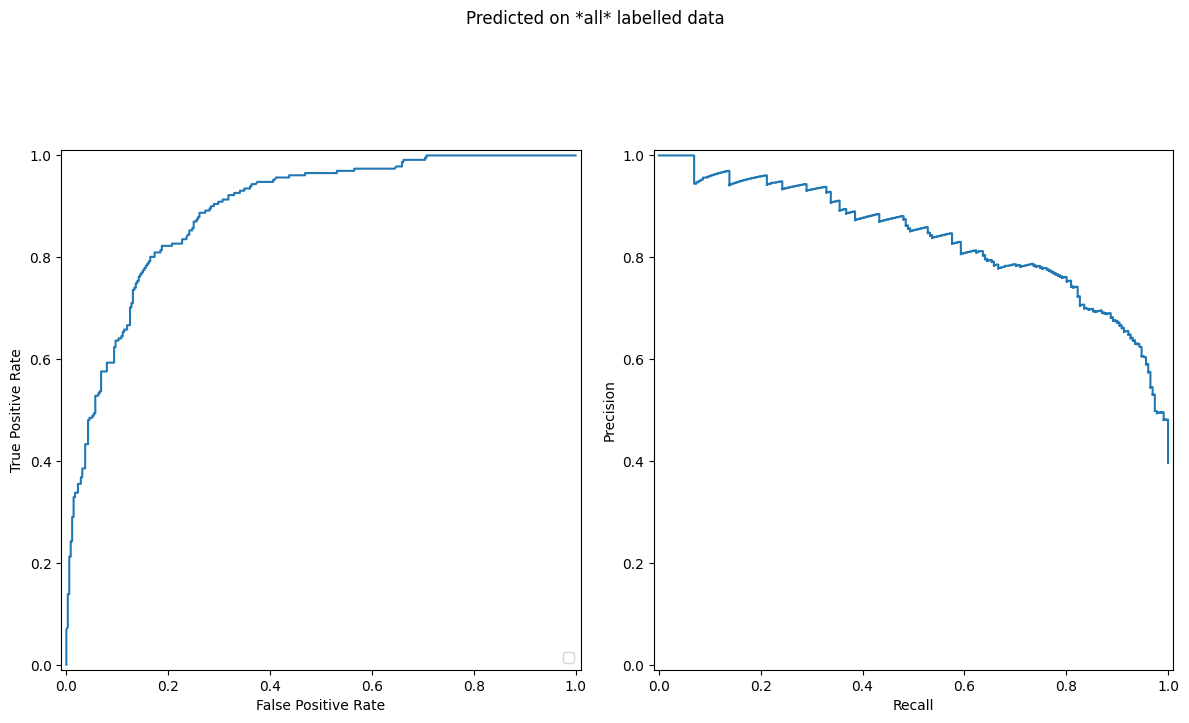

In [20]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

y_true = df['incl']
y_scores = df['pred|1']
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
print(precision)
print(recall)
print(thresholds)

from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

y_true = df[df['item_id'].isin(eval_dataset['item_id'])]['incl']
y_pred = df[df['item_id'].isin(eval_dataset['item_id'])]['pred|1']

fpr, tpr, _ = roc_curve(y_true, y_pred)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Predicted on *all* labelled data')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
fig.tight_layout()
plt.show()

/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


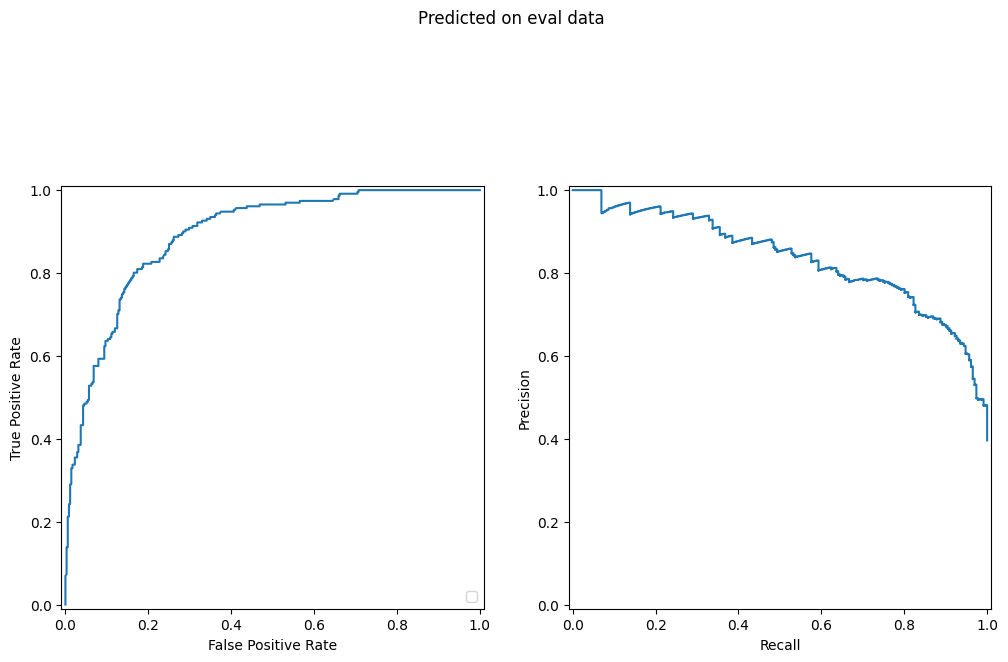

In [21]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

y_true = df[df['item_id'].isin(eval_dataset['item_id'])]['incl']
y_pred = df[df['item_id'].isin(eval_dataset['item_id'])]['pred|1']

fpr, tpr, _ = roc_curve(y_true, y_pred)
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fig.suptitle('Predicted on eval data')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

In [22]:
pd.DataFrame([precision, recall, thresholds])
#(y_pred>0.95).sum()

0         1         2         3         4         5         6    \
0  0.396226  0.396907  0.397590  0.398276  0.398964  0.399654  0.400347   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000342  0.000345  0.000346  0.000349  0.000353  0.000353  0.000356   

        7         8         9         10        11        12        13   \
0  0.401042  0.401739  0.402439  0.403141  0.403846  0.404553  0.405263   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000357  0.000361  0.000363  0.000363  0.000363  0.000367  0.000369   

        14        15        16        17       18        19        20   \
0  0.405975  0.406690  0.407407  0.408127  0.40885  0.409574  0.410302   
1  1.000000  1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   
2  0.000371  0.000376  0.000376  0.000379  0.00038  0.000387  0.000390   

        21        22        23        24        25        26        27   \
0  0.411032  0.411765  0.412500  0.413238  0.413978  0.414722  0.415468   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000392  0.000393  0.000394  0.000399  0.000406  0.000406  0.000408   

        28        29        30        31        32        33        34   \
0  0.416216  0.416968  0.417722  0.418478  0.419238  0.420000  0.420765   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000409  0.000411  0.000414  0.000418  0.000419  0.000419  0.000421   

        35        36        37        38        39        40        41   \
0  0.421533  0.422303  0.423077  0.423853  0.424632  0.425414  0.426987   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000422  0.000423  0.000424  0.000425  0.000428  0.000429  0.000430   

        42        43        44        45        46        47        48   \
0  0.427778  0.428571  0.429368  0.430168  0.430970  0.431776  0.432584   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000430  0.000435  0.000438  0.000441  0.000443  0.000444  0.000445   

        49        50        51        52        53        54        55   \
0  0.433396  0.434211  0.435028  0.435849  0.436673  0.437500  0.438330   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000445  0.000447  0.000447  0.000451  0.000452  0.000452  0.000453   

        56        57        58        59        60        61        62   \
0  0.439163  0.440000  0.440840  0.441683  0.442529  0.443378  0.444231   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000455  0.000458  0.000461  0.000465  0.000467  0.000470  0.000471   

        63        64        65        66        67        68        69   \
0  0.445087  0.445946  0.446809  0.447674  0.448544  0.449416  0.450292   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000472  0.000474  0.000480  0.000482  0.000484  0.000486  0.000493   

        70        71        72        73        74        75        76   \
0  0.451172  0.452055  0.452941  0.453831  0.454724  0.455621  0.456522   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000494  0.000495  0.000495  0.000496  0.000496  0.000498  0.000501   

        77        78        79        80        81        82        83   \
0  0.457426  0.458333  0.459245  0.460159  0.461078  0.462000  0.462926   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000503  0.000513  0.000514  0.000517  0.000521  0.000523  0.000523   

        84        85        86        87        88        89        90   \
0  0.463855  0.464789  0.465726  0.466667  0.467611  0.468560  0.469512   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000524  0.000525  0.000526  0.000535  0.000535  0.000549  0.000551   

        91        92        93        94        95        96        97   \
0  0.470468  0.471429  0

In [23]:
tradeoff = 226
print('total unseen items:', len(y_pred))
print('precision', precision[tradeoff])
print('recall', recall[tradeoff])
print('threshold', thresholds[tradeoff])
print('to annotate:', (y_pred >= thresholds[tradeoff]).sum())
print('ignored:', (y_pred < thresholds[tradeoff]).sum())
print('num possibly missed:', len(y_pred) * (1 - recall[tradeoff]))
print('num docs to annotate that are probably not relevant:', (y_pred>=thresholds[tradeoff]).sum() * (1 - precision[tradeoff]))

total unseen items: 583
precision 0.6221590909090909
recall 0.948051948051948
threshold 0.0024100866
to annotate: 352
ignored: 231
num possibly missed: 30.285714285714295
num docs to annotate that are probably not relevant: 133.0
